# cell type情報

1. 野生型マウス海馬CA1領域の切片（CK2WtCA1）
2. 野生型マウス海馬歯状回領域の切片（CK2WT）
3. CamK2aヘテロノックアウトマウス海馬歯状回（CK2KO）
4. CamK2aヘテロノックアウトマウス海馬（CK2KOCA1）
5. マウス胎仔脳切片で神経幹細胞が多く集積しているところ
6. マウス胎仔脳切片で分化した未成熟ニューロンが集積しているところ


# 染色種類

**クラス1 ~ クラス4**

* 488は転写共役因子`CTCF`を染色したものです。CTCFは`３次元的にゲノム領域を分けるboundaryに集積する`（TADの境界に集積する）タンパク質です。

* 555はヒストンH3タンパク質の９番目のリジン残基がトリメチル化されたもの`（H3K9me3）`を染色しております。H3K9me3は`ヘテロクロマチン`に集積します。

**クラス5 ~ クラス6**

* 488はエンハンサー領域に集積する`H3K4me1`となっております。
* 555は核膜に存在する`LaminB1`となっております。

# SegmentData

* **1_488_STED_decon** : 35
* **2_488_STED_decon** : 30
* **3_488_STED_decon** : 39
* **4_488_STED_decon** : 25


* **5_488_STED_decon** : 30
* **6_488_STED_decon** : 54

# データ確認

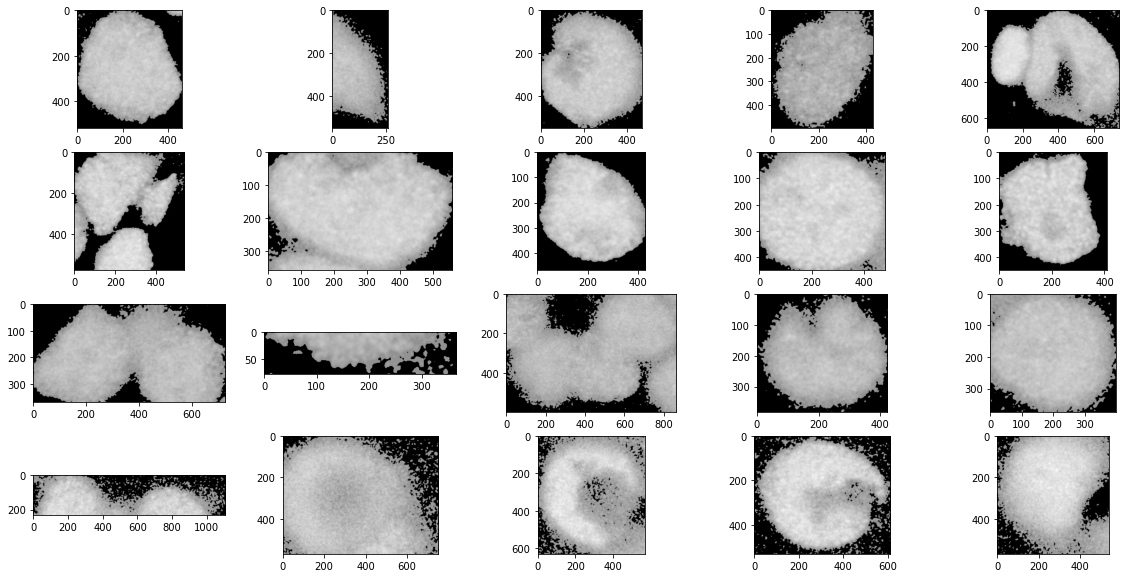

In [2]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import regularizers

path = "./SegmentData/1234_STED_decon_CTCF/"
name = "_488_STED_decon_gamma10_"
classes = ["1","2","3","4"]

fig, ax = plt.subplots(2,2, figsize = (20,10))
subnumber=1
for n in range(4):
    for i in range(5):
#         print(path+classes[n]+name+str(i)+".tif")
        img = cv2.imread(path+classes[n]+name+str(i)+".tif")
        plt.subplot(4,5,subnumber)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        subnumber+=1
        
plt.show()

# データの読み込み

In [65]:
path = "./SegmentData/1234_STED_H3K9me3/"
DataPath=[]
DataLabel=[]

for root,dirs,files in os.walk(path):
    for file_name in files:
        path = os.path.join(root,file_name)
        label = os.path.join(file_name)
        DataPath.append(path)
        DataLabel.append(label[0])
# all_files.remove("../Database/KIMIA_Path_960/train/.DS_Store")
# file_label.remove(".")
print(len(DataPath))
print(len(DataLabel))

128
128


In [66]:
print("DataNames: ",DataPath[1])
print("DataLabels: ",DataLabel[1])

DataNames:  ./SegmentData/1234_STED_H3K9me3/4_555_STED_gamma10_3.tif
DataLabels:  4


len(kp):  4502


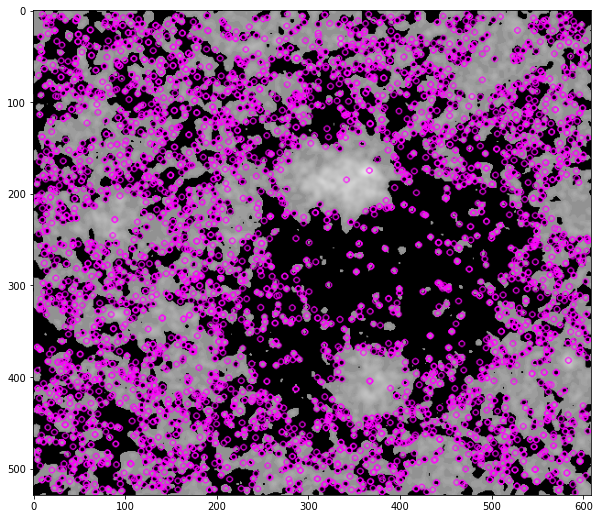

In [75]:
img = cv2.imread("./SegmentData/1234_STED_decon_H3K9me3/4_555_STED_decon_gamma10_3.tif")

sift = cv2.SIFT_create()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #灰度处理图像
kp, des = sift.detectAndCompute(gray,None)   #des是描述子
img_kp = cv2.drawKeypoints(img, kp, gray, color=(255,0,255)) #画出特征点，并显示为红色圆圈
print("len(kp): ", len(kp))

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
plt.show()

# 特徴点の抽出

In [67]:
k = 10
detector = cv2.SIFT_create()
trainer = cv2.BOWKMeansTrainer(k)

keypoints = []
directors = []

DataPathremove = []
DataLabelremove = []

for i in range(len(DataPath)):
    path = DataPath[i]
    img = cv2.imread(path)
    ks, ds = detector.detectAndCompute(img, None)
    if len(ks) == 0:
        print("Keypoint of ", path," is None, so remove it from DataPath")
    else:
        DataPathremove.append(DataPath[i])
        DataLabelremove.append(DataLabel[i])
        trainer.add(ds.astype(np.float32))
        keypoints.append(ks)
        directors.append(ds)
     
DataPath = DataPathremove
DataLabel = DataLabelremove
print("After remove it, len(DataPath) is ", len(DataPath))

Keypoint of  ./SegmentData/1234_STED_H3K9me3/4_555_STED_gamma10_3.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/1_555_STED_gamma10_34.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/4_555_STED_gamma10_15.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/1_555_STED_gamma10_9.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/3_555_STED_gamma10_36.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/4_555_STED_gamma10_0.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/1_555_STED_gamma10_26.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/3_555_STED_gamma10_30.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234_STED_H3K9me3/1_555_STED_gamma10_23.tif  is None, so remove it from DataPath
Keypoint of  ./SegmentData/1234

# クラスタリング

In [76]:
dictionary = trainer.cluster()
print("dictionary: ",dictionary.shape)

dictionary:  (10, 128)


In [77]:
dictionary[1]

array([ 26.496489,  26.1987  ,  28.040833,  28.043173,  26.56333 ,
        23.449415,  21.205982,  21.815346,  48.62861 ,  38.314693,
        29.667881,  26.06502 ,  26.89805 ,  26.60156 ,  27.016125,
        35.25514 ,  30.777634,  29.502731,  32.519375,  37.23823 ,
        38.385437,  34.383877,  27.923018,  27.148504,  27.106112,
        27.471262,  28.783096,  28.321457,  25.170351,  22.395319,
        22.017946,  24.32952 ,  31.492329,  27.080885,  33.27204 ,
        46.320156,  49.100132,  35.480625,  21.258257,  18.717556,
       114.92406 ,  47.050716,  22.072561,  19.879583,  24.777374,
        34.20156 ,  34.518597,  64.51183 ,  34.567753,  19.243174,
        19.838491,  31.56099 ,  84.06606 ,  94.539406,  48.992718,
        32.83459 ,  36.475163,  35.737843,  32.62991 ,  28.56177 ,
        30.86138 ,  33.16021 ,  31.23095 ,  33.581276,  30.491549,
        18.148766,  21.308193,  36.00156 ,  49.247597,  46.965412,
        33.408062,  26.416645, 116.28088 ,  74.46164 ,  28.938

# ヒストグラム

In [78]:
matcher = cv2.BFMatcher()
extractor = cv2.BOWImgDescriptorExtractor(detector, matcher)
extractor.setVocabulary(dictionary)
descriptor_list = []
for path in DataPath:
    img = cv2.imread(path)
    ks = detector.detect(img, None)
    descriptor = extractor.compute(img, ks)[0]
    descriptor_list.append(descriptor)

print("descriptor: ",type(descriptor))
print("descriptor: ",descriptor.shape)
print("descriptor_list: ",type(descriptor_list))
print("descriptor_list: ",len(descriptor_list))

descriptor:  <class 'numpy.ndarray'>
descriptor:  (10,)
descriptor_list:  <class 'list'>
descriptor_list:  30


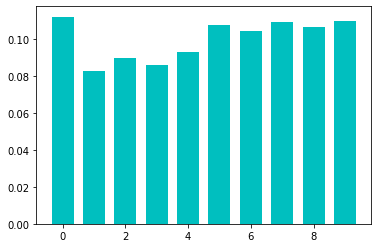

In [79]:
hist = descriptor_list[1]
x = [0,1,2,3,4,5,6,7,8,9]

plt.bar(x, hist, 0.7, color='c')
plt.show()

# BPNN画像分類

In [1]:
# divide each classes into train and test 
data_descriptor = np.array(descriptor_list)
data_intlabel = LabelEncoder().fit(DataLabel).transform(DataLabel)

data_descriptor_class=[[],[],[],[]]
data_intlabel_class=[[],[],[],[]]
for i in range(len(data_intlabel)):
    data_descriptor_class[data_intlabel[i]].append(data_descriptor[i])
    data_intlabel_class[data_intlabel[i]].append(data_intlabel[i])

X_train, X_test, y_train, y_test = [],[],[],[]
for i in range(len(data_descriptor_class)):
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(np.array(data_descriptor_class[i]), np.array(data_intlabel_class[i]), test_size=0.3, random_state=42)        
    X_train.extend(X_train_class), X_test.extend(X_test_class), y_train.extend(y_train_class), y_test.extend(y_test_class)

X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# shuffle
train_permutation = np.random.permutation(X_train.shape[0])
test_permutation = np.random.permutation(X_test.shape[0])
X_train,y_train, = X_train[train_permutation, :],y_train[train_permutation] 
X_test,y_test = X_test[test_permutation, :],y_test[test_permutation]


In [62]:
model_l2_dropout = keras.Sequential([
    keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001),activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001),activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, kernel_regularizer=regularizers.l2(0.001),activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, kernel_regularizer=regularizers.l2(0.001),activation='softmax')
])

model_l2_dropout.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
epochs = 100
model_l2_dropout.fit(X_train, y_train, epochs=epochs)

Epoch 1/100
87/87 [==============================] - 0s 2ms/sample - loss: 1.9293 - acc: 0.1954
Epoch 2/100
87/87 [==============================] - 0s 94us/sample - loss: 1.8913 - acc: 0.3678
Epoch 3/100
87/87 [==============================] - 0s 99us/sample - loss: 1.8565 - acc: 0.3448
Epoch 4/100
87/87 [==============================] - 0s 94us/sample - loss: 1.8243 - acc: 0.4483
Epoch 5/100
87/87 [==============================] - 0s 92us/sample - loss: 1.7967 - acc: 0.4943
Epoch 6/100
87/87 [==============================] - 0s 97us/sample - loss: 1.7584 - acc: 0.4943
Epoch 7/100
87/87 [==============================] - 0s 98us/sample - loss: 1.7255 - acc: 0.4598
Epoch 8/100
87/87 [==============================] - 0s 91us/sample - loss: 1.6884 - acc: 0.4943
Epoch 9/100
87/87 [==============================] - 0s 90us/sample - loss: 1.6299 - acc: 0.5057
Epoch 10/100
87/87 [==============================] - 0s 104us/sample - loss: 1.5945 - acc: 0.4943
Epoch 11/100
87/87 [=========

In [64]:
test_loss, test_acc = model_l2_dropout.evaluate(X_test, y_test)
print('\n model_l2_dropout Test accuracy:', test_acc)

40/40 [==============================] - 0s 2ms/sample - loss: 1.1078 - acc: 0.5250

 model_l2_dropout Test accuracy: 0.525


# baseline

* True Positive(真正, TP)：将正类预测为正类数. 
* True Negative(真负, TN)：将负类预测为负类数. 
* False Positive(假正, FP)：将负类预测为正类数 →→ 误报 (Type I error). 
* False Negative(假负 , FN)：将正类预测为负类数 →→ 漏报 (Type II error).

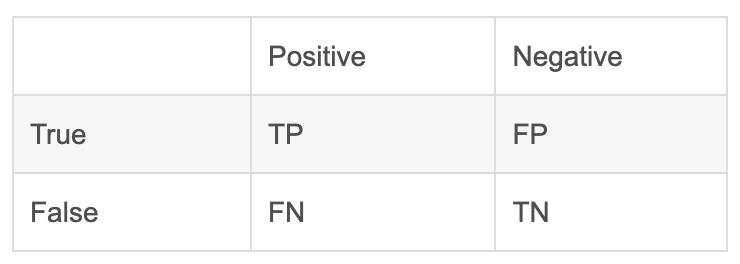

* **Accuracy** : Acc = (tp + tn) / (tp + tn + fp + fn)
* **Precision** : P = tp / (tp + fp)

In [14]:
print("Total number of y_train : ", len(y_train))
print("y_train_class_1 num : ", y_train.tolist().count(0))
print("y_train_class_2 num : ", y_train.tolist().count(1))
print("y_train_class_3 num : ", y_train.tolist().count(2))
print("y_train_class_4 num : ", y_train.tolist().count(3))
print("")
print("Total number of y_test : ", len(y_test))
print("y_test_class_1 num : ", y_test.tolist().count(0))
print("y_test_class_2 num : ", y_test.tolist().count(1))
print("y_test_class_3 num : ", y_test.tolist().count(2))
print("y_test_class_4 num : ", y_test.tolist().count(3))

Total number of y_train :  88
y_train_class_1 num :  24
y_train_class_2 num :  21
y_train_class_3 num :  27
y_train_class_4 num :  16

Total number of y_test :  40
y_test_class_1 num :  11
y_test_class_2 num :  9
y_test_class_3 num :  12
y_test_class_4 num :  8


In [16]:
# Random guessing: 
P_class_1 = 24/89
P_class_2 = 21/89
P_class_3 = 27/89
P_class_4 = 16/89

# Expectation (acc) over 
P_class = 1/40 * ((11*P_class_1) + (9*P_class_2) + (12*P_class_3) + (8*P_class_4))
P_class

0.25421348314606745

-------

----------

-----

len(kp):  1306


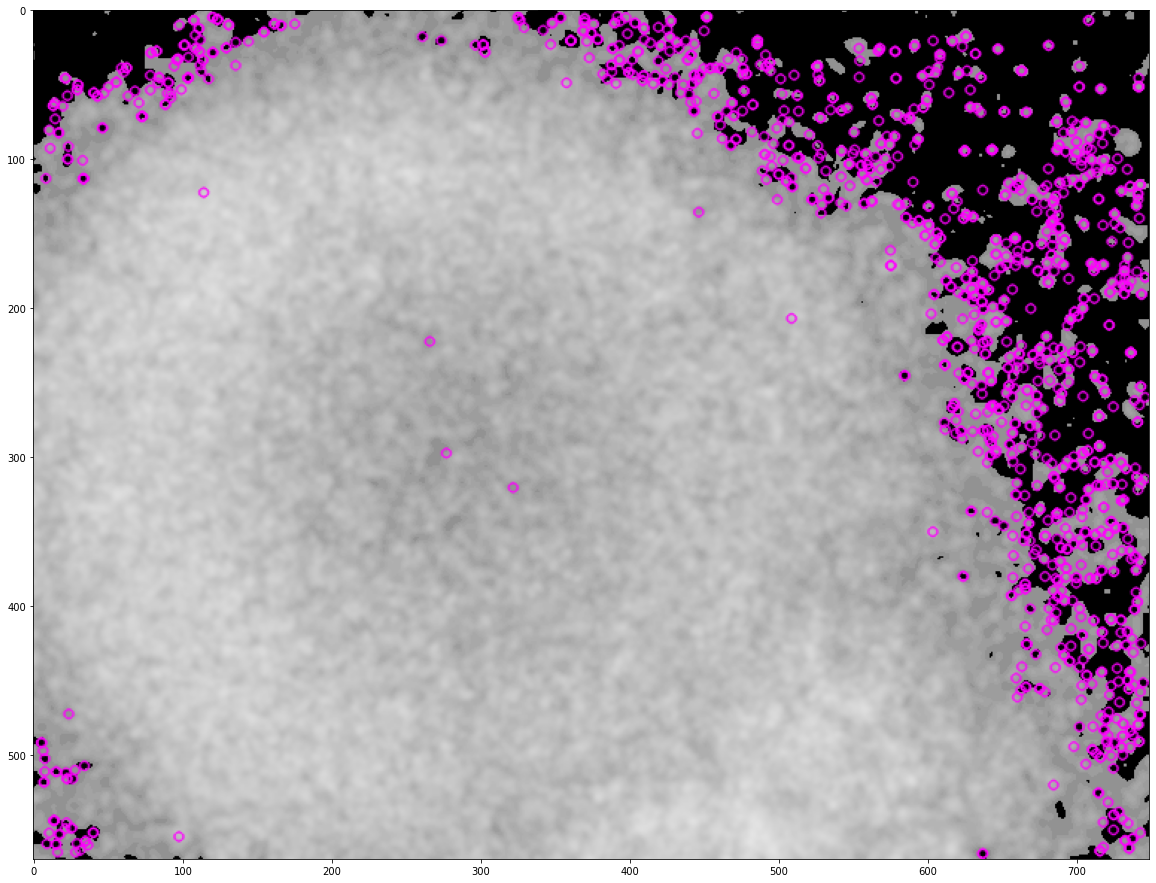

In [27]:
# path="./DataOrigin/1/1_555_STED_C1-191212_CK2WtCA1_488_CTCF_555_K9Me3.lif - Series001_STED.tif"
img = cv2.imread(DataPath[2])

sift = cv2.SIFT_create()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #灰度处理图像
kp, des = sift.detectAndCompute(gray,None)   #des是描述子
img_kp = cv2.drawKeypoints(img, kp, gray, color=(255,0,255)) #画出特征点，并显示为红色圆圈
print("len(kp): ", len(kp))

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
plt.show()